In [1]:
import torch
import sys
from matplotlib import gridspec
from matplotlib import pyplot as plt
sys.path.append('src')
from score_util_pub import *
from inference import *
import json

/home/grads/xiaoyanzang24/miniconda3/envs/C3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## For SDXL-Turbo


### It seems that turbo doesn't call up block, so use SDXL-light to test

In [ ]:
model = Generator('sdxl-turbo')
# print(dir(model))

In [ ]:
seed = 3
prompt = 'a creative chair'
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.075 # amp factor for down 0 block
amplification_factor[1] = 1.15 # amp factor for down 1 block
amplification_factor[2] = 2.6 # amp factor for down 2 block
amplification_factor[3] = 2.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

file_path = f'./results/sdxl-turbo/chair/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.3
amplification_factor[1] = 1+(data[0][1]-1)*0.3
amplification_factor[2] = 1+(data[0][2]-1)*0.2
amplification_factor[3] = 1+(data[0][3]-1)*0.2


In [ ]:
orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor)
dual = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor)

In [ ]:
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('C3')
ax3.imshow(dual)
ax3.axis('off')
ax3.set_title('Ours')
plt.tight_layout()
plt.show()

In [ ]:
prompt = 'a creative teddy bear'

orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor)


gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()


----

## For SDXL-Lightning

In [2]:
model = Generator('sdxl-light-1')

/home/grads/xiaoyanzang24/cv/C3/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]


In [3]:
seed = 42
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.1 # amp factor for down 0 block
amplification_factor[1] = 1.3 # amp factor for down 1 block
amplification_factor[2] = 1.6 # amp factor for down 2 block
amplification_factor[3] = 1.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

# file_path = f'./results/sdxl-light-1/house/amp_factors_80.json'
file_path = f'./results/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.2
amplification_factor[1] = 1+(data[0][1]-1)*0.2
amplification_factor[2] = 1+(data[0][2]-1)*0.1
amplification_factor[3] = 1+(data[0][3]-1)*0.1


### house

In [4]:
prompt = 'a creative chair'
orig = model.orig(prompt=prompt, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
go to up block


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


In [5]:
c3 = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0])

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0


In [6]:
## only apply up blocks transformation
up_trans = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8, saliency_fft=False)
## only apply saliency gating
down_saliency = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], apply_filter=False, filter_factor=0.8, saliency_fft=True)
dual = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor,cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up


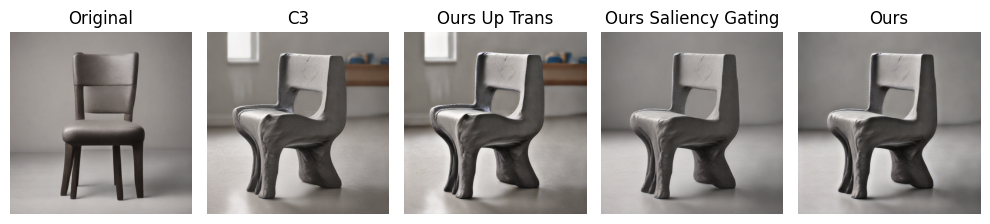

In [7]:
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(c3)
ax2.axis('off')
ax2.set_title('C3')

ax3.imshow(up_trans)
ax3.axis('off')
ax3.set_title('Ours Up Trans')

ax4.imshow(down_saliency)
ax4.axis('off')
ax4.set_title('Ours Saliency Gating')

ax5.imshow(dual)
ax5.axis('off')
ax5.set_title('Ours')
plt.tight_layout()
plt.show()

### cabin

In [8]:
prompt = 'a creative log cabin'
orig = model.orig(prompt=prompt, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
go to up block


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


In [9]:
c3 = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0])

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0


In [10]:
up_trans = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8, saliency_fft=False)
down_saliency = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], apply_filter=False, filter_factor=0.8, saliency_fft=True)
dual = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor,cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up


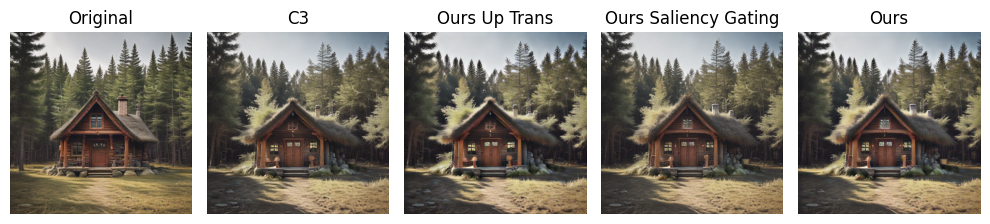

In [11]:
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(c3)
ax2.axis('off')
ax2.set_title('C3')

ax3.imshow(up_trans)
ax3.axis('off')
ax3.set_title('Ours Up Trans')

ax4.imshow(down_saliency)
ax4.axis('off')
ax4.set_title('Ours Saliency Gating')

ax5.imshow(dual)
ax5.axis('off')
ax5.set_title('Ours')
plt.tight_layout()

  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
go to up block


  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply fft on low, replace_mask:  1.1199999999999999
apply fft on low, replace_mask:  1.7000000000000002
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0



  0%|          | 0/1 [00:00<?, ?it/s]

>>> ENTER UNET FORWARD
apply fft on low, replace_mask:  1.08
apply saliencyon down blocks
apply fft on low, replace_mask:  1.1199999999999999
apply saliencyon down blocks
apply fft on low, replace_mask:  1.7000000000000002
apply saliencyon down blocks
run fft on mid
go to up block


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up
up block - hidden_mask is not none
UP BLOCK replace_on TYPE/VALUE: <class 'str'> freq
UP BLOCK replace_mask 1.0
run gabor on up


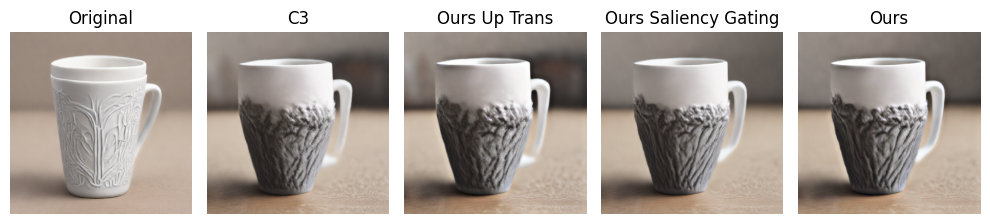

In [15]:
prompt = 'a creative cup'
orig = model.orig(prompt=prompt, seed=seed)

c3 = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0])

up_trans = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8, saliency_fft=False)
down_saliency = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], apply_filter=False, filter_factor=0.8, saliency_fft=True)
dual = model.dual_stage(prompt=prompt, seed=seed, replace_mask=amplification_factor,cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0], filter_factor=0.8)

gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(c3)
ax2.axis('off')
ax2.set_title('C3')

ax3.imshow(up_trans)
ax3.axis('off')
ax3.set_title('Ours Up Trans')

ax4.imshow(down_saliency)
ax4.axis('off')
ax4.set_title('Ours Saliency Gating')

ax5.imshow(dual)
ax5.axis('off')
ax5.set_title('Ours')
plt.tight_layout()
